In [1]:
# Wavelet transform and Mass mapping jupyter notebook
# Experiment 1: 
#     - Take the starlet transform of an image
#     - Caculate the standard deviation of each wavelet scale
#     - Reconstruct an image from its coefficients and check that the reconstruction is exact
# Experiment 2: inpainting a convergence map using the Discrete Cosine Transform
# Experiment 3: Gaussian Denoising
#      - Create a 2D Gaussian in a 2D image
#      - Add some Gaussian noise to the image.
#      - Perform a wavelet thresholding
#      - Check if the Gaussian is detected.
#      - Reconstruct a denoising image from the thresholded coefficients
# Experiment 4: Do mass map reconstruction with different methods on COSMOS data
#      - Kaiser-Squires
#      - Proximal Wiener
#      - Sparsity
#      - MCAlens

In [2]:
print("Hello")
# from pysap.data import get_sample_data
from my_cosmostat.misc.cosmostat_init import *
from my_cosmostat.misc.mr_prog import *
from my_cosmostat.misc.im1d_tend import *
from my_cosmostat.misc.utilHSS import *
from my_cosmostat.misc.stats import *
from my_cosmostat.sparsity.sparse2d.starlet import *

Hello
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Warning in starlet.py: do not find pysap bindings ==> use slow python code. 


In [3]:
# Experiment 4: Do mass map reconstruction with different methods on COSMOS data
# Routine for COSMOS EXPERIMENT

# Need the following routines
from my_cosmostat.astro.wl.mass_mapping import *
from my_cosmostat.misc.im_isospec import *
# Function for drawing the data footprint
DEF_lut='inferno'
    
def tvradec(ima, title='ima',vmin=None,vmax=None,smooth=None,xclus=False,mtext=False,m500min=0, zmin=0.3,zmax=1,ztext=False,lut=DEF_lut,filename=None,extent_radec=None):
    if extent_radec is None:
        # extent_radec = get_extend_radec()
        extent_radec = [149.35, 150.9, 1.5, 2.95]

    fs = 18 # fontsize        
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    # Kappa map
    if smooth is None:
        imaS = ima
    else:
        imaS = gf(ima, smooth)
    img = ax.imshow(imaS, origin='lower', cmap=lut, vmin=vmin, vmax=vmax, extent=extent_radec)
    # draw_footprint(ax)
    
    # Xray clusters
    if xclus:
        xclusters = np.loadtxt("xray.txt")
        highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
        for cluster in xclusters[highz]:
            ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
            m500 = cluster[7]
            if m500 > m500min:
                ax.scatter(ra_cl, dec_cl, c='w', s=12)
                if ztext:
                    ax.text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')
                if mtext:
                    ax.text(ra_cl + 0.03, dec_cl - 0.02, "{:.2f}".format(m500), fontsize=8, c='w')

    # Clean up and decorate
    ax.set_aspect('equal')
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_title(title, fontsize=fs)
    ax.set_xlabel("RA [deg]", fontsize=fs)
    ax.set_ylabel("Dec [deg]", fontsize=fs)
    fig.colorbar(img, ax=ax)
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [5]:
# Read the COSMOS data. The catalog has already be binned

# e1map = readfits('cosmos_g1.fits')  # first component image of the shear
# e2map = readfits('cosmos_g2.fits')  # second component image of the shear
# galmap = readfits('cosmos_countmap.fits') # number of galaxies per pixel 
# ps1d = readfits('cosmos_estimated_signal_powspec.fits') # estimated theoretical power spectrum
# pn = readfits('cosmos_estimated_noise_powspec.fits')    # estimated noise power spectrum

e1map = - fits.open('/Users/danny/Desktop/cos0_Set1_rotate1_area1_37_gamma1.fits')[0].data
e2map = fits.open('/Users/danny/Desktop/cos0_Set1_rotate1_area1_37_gamma2.fits')[0].data
kappa = fits.open('/Users/danny/Desktop/cos0_Set1_rotate1_area1_37_kappa.fits')[0].data

# e1map = - fits.open('/Users/danny/Desktop/cos0_Set1_rotate1_area1_37_gamma1.fits')[0].data[0:256, 0:256]
# e2map = fits.open('/Users/danny/Desktop/cos0_Set1_rotate1_area1_37_gamma2.fits')[0].data[0:256, 0:256]
# kappa = fits.open('/Users/danny/Desktop/cos0_Set1_rotate1_area1_37_kappa.fits')[0].data[0:256, 0:256]

ps1d = im_isospec(kappa)
# ps1d = fits.open('/Users/danny/Desktop/WL/kappa_map/scripts/signal_power_spectrum.fits')[0].data

# Create the covariance matrix, assumed to be diagonal
CovMat = np.ones((1024, 1024)) * 0.04

# Create the mass mapping structure and initialise it
M = massmap2d(name='mass')
M.init_massmap(1024, 1024)
M.DEF_niter = 100
Bmode = True

pn = M.get_noise_powspec(CovMat=CovMat, nsimu=10)
# pn = fits.open('/Users/danny/Desktop/WL/kappa_map/scripts/noise_power_spectrum.fits')[0].data

In [6]:
vmin=-0.03
vmax=0.1
zmax=0.99
m500min=3
mtext=False # overplot x-clusters M500
ztext=True # overplot x-clusters redshift
Sigma2Fwhm = 2.355
smooth= 1.2 / Sigma2Fwhm   # resolution in Massey 07 paper
xclus=False # True to overplot x-clusters
lut=DEF_lut
# tvradec(galmap, 'Galaxy number count',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)

/var/folders/cb/fs27ksbj131c_0qrcl46hk740000gn/T/ipykernel_7434/2228557131.py:9: RuntimeWarning: divide by zero encountered in divide
  D_starkernel = -1. / (theta_x + 1j*theta_y) ** 2
/var/folders/cb/fs27ksbj131c_0qrcl46hk740000gn/T/ipykernel_7434/2228557131.py:9: RuntimeWarning: invalid value encountered in divide
  D_starkernel = -1. / (theta_x + 1j*theta_y) ** 2


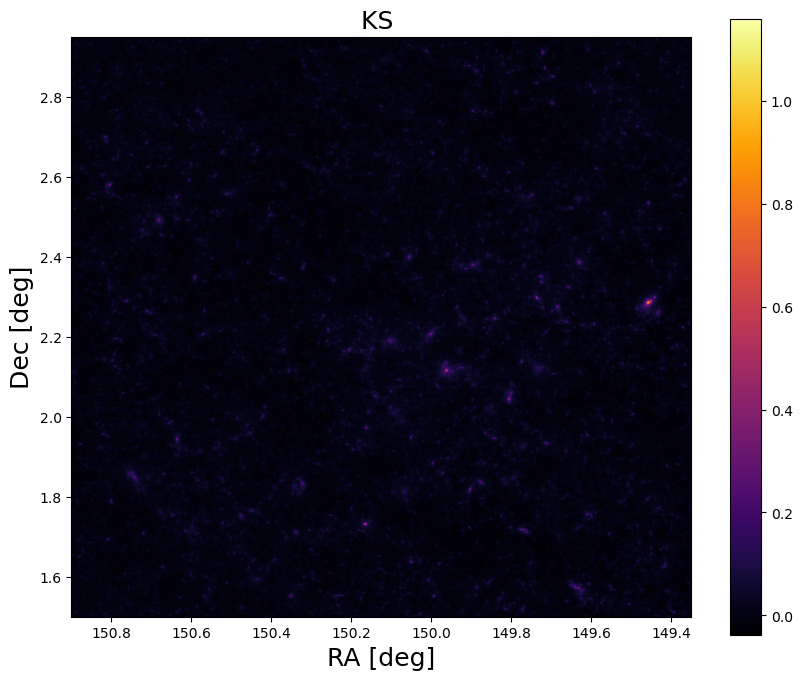

In [9]:
import numpy as np
from scipy.fft import fft2, ifft2
from astropy.io import fits

def shear_rec(shear1, shear2):
    N_grid = shear1.shape[0]
    theta = np.linspace(-N_grid+1, N_grid-1, 2*N_grid-1)
    theta_x, theta_y = np.meshgrid(theta, theta)
    D_starkernel = -1. / (theta_x + 1j*theta_y) ** 2
    D_starkernel[N_grid-1, N_grid-1] = 0
    y = np.real(ifft2(fft2(D_starkernel, (3*N_grid-2, 3*N_grid-2)) * fft2(shear1 + 1j*shear2, (3*N_grid-2, 3*N_grid-2)))) / np.pi
    y = y[N_grid-1:2*N_grid-1, N_grid-1:2*N_grid-1]
    return y

rec = shear_rec(shear1=e1map, shear2=e2map)
tvradec(rec, title='KS ',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)

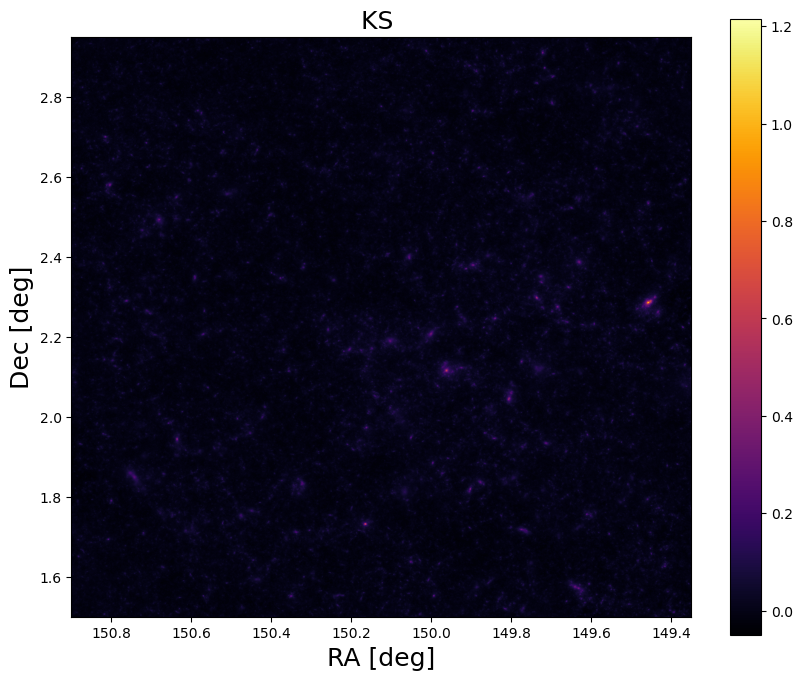

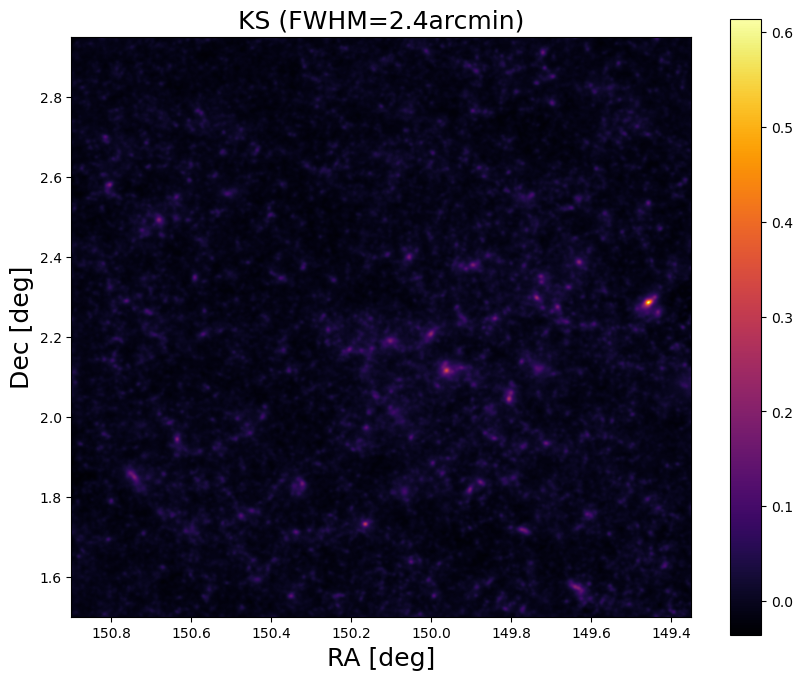

In [13]:
# Calculate the Kaiser-Squires reconstruction, and smooth it
ks =  M.g2k(e1map,e2map)
ks2 = M.smooth(ks, sigma=2)
tvradec(ks, title='KS ',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)
tvradec(ks2, title='KS (FWHM=2.4arcmin)',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)

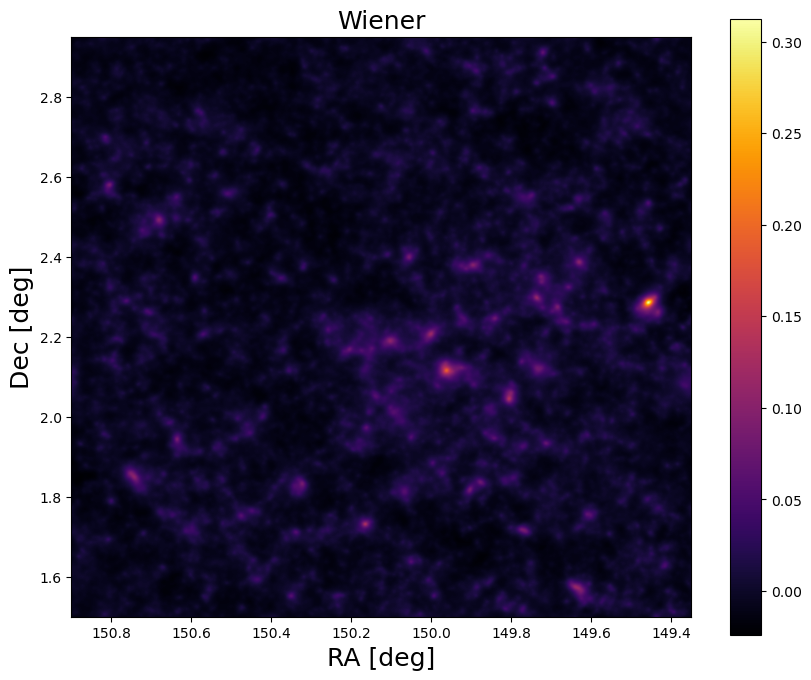

In [16]:
retr, reti = M.wiener(e1map, e2map, ps1d, pn)
tvradec(retr, title='Wiener',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)

In [31]:
# Perform the proximal wiener filtering
kiw,iwi = M.prox_wiener_filtering(e1map, e2map, ps1d, D.Ncov, Inpaint=False, Pn=pn) #, Pn=Pn) # ,ktr=InShearData.ktr)
tvradec(kiw, title='Wiener',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)

# Perform the proximal inpainted wiener filtering
kiw,iwi = M.prox_wiener_filtering(e1map, e2map, ps1d, D.Ncov, Inpaint=True, Pn=pn) #, Pn=Pn) # ,ktr=InShearData.ktr)
tvradec(kiw, title='Inpainted Wiener',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)

ValueError: operands could not be broadcast together with shapes (361,) (512,512) 

In [32]:
# Do a sparse reconstruction with a 4 sigma detection
ksr4,ti = M.sparse_recons(D, UseNoiseRea=False,Nsigma=4, ThresCoarse=False, Inpaint=False,Nrea=None)
tvradec(ksr4, title='Sparsity (lambda=4)',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)

# Do a sparse reconstruction with a 5 sigma detection
ksr5,ti = M.sparse_recons(D, UseNoiseRea=False,Nsigma=5, ThresCoarse=False, Inpaint=False,Nrea=None)
tvradec(ksr5, title='Sparsity (lambda=5)',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)

KeyboardInterrupt: 

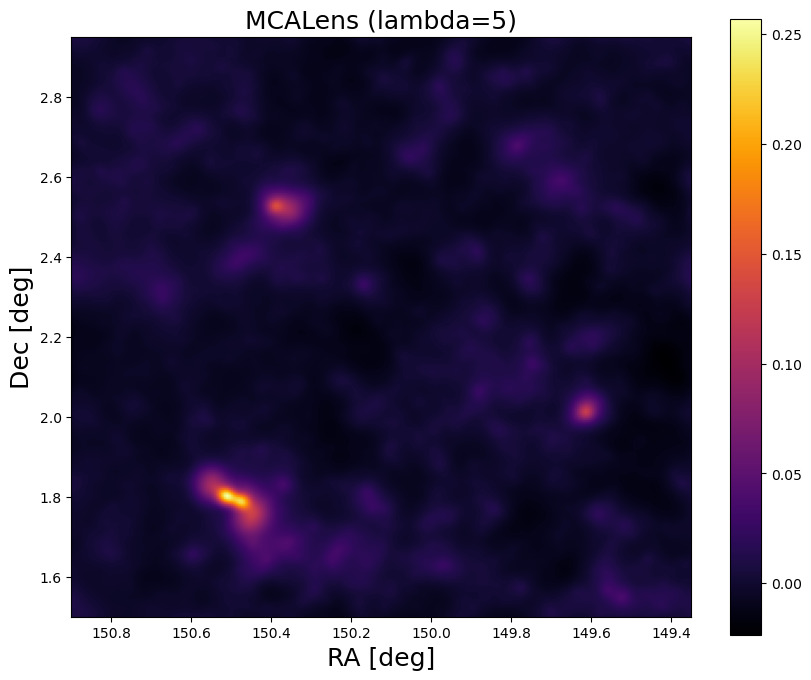

In [ ]:
# MCAlens reconstruction with a 5sigma detection
k1r5,k1i5,k2r5,k2i = M.sparse_wiener_filtering(D, ps1d, Nsigma=5, Inpaint=False, Bmode=Bmode, ktr=None)
tvradec(k1r5, title='MCALens (lambda=5)',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)